# Deep CORAL

This is the implementation for the following paper:
```
@inproceedings{sun2016deep,
  title={Deep coral: Correlation alignment for deep domain adaptation},
  author={Sun, Baochen and Saenko, Kate},
  booktitle={Computer Vision--ECCV 2016 Workshops: Amsterdam, The Netherlands, October 8-10 and 15-16, 2016, Proceedings, Part III 14},
  pages={443--450},
  year={2016},
  organization={Springer}
}
```

The paper is also available [here](./res/Deep%20CORAL%20-%20Correlation%20Alignment%20for%20Deep%20Domain%20Adaptation.pdf).

### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchinfo import summary

from torch.utils.tensorboard import SummaryWriter

np.random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
import _base_model
import _dataloader_helper

#### For logging multiple runs

In [3]:
import pathlib

log_root = pathlib.Path(f'./coral')
run_id = 1
while True:
    log_dir = log_root/f'run{run_id}'
    if not log_dir.exists():
        break
    run_id += 1

# use a previous run
# log_dir = log_root/'run1'
log_dir.mkdir(parents=True, exist_ok=True)
print(f'Logging to: {log_dir}')

Logging to: coral\run1


### Prepare dataset

Here, we transform both the source and target datasets into the same size, and repeat the channel dimension for grayscale images, such that both datasets have the same input shape to the model.

In [4]:
input_shape = (3, 32, 32)
num_classes = 10

loader_helper = _dataloader_helper.MNIST2USPS(image_size=input_shape[1:])
src_train, src_val, src_test = loader_helper.get_src_loaders()
tgt_train, tgt_val, tgt_test = loader_helper.get_tgt_loaders()

#### Visualize some samples from both domains

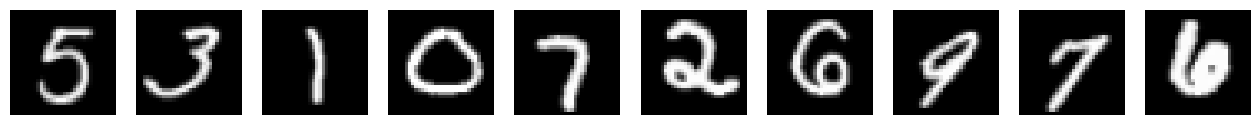

torch.Size([10, 3, 32, 32])
tensor([5, 3, 1, 0, 7, 2, 6, 9, 7, 6])


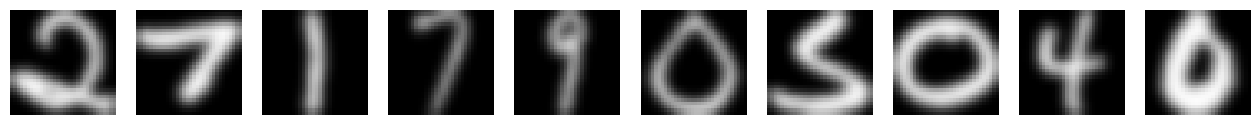

torch.Size([10, 3, 32, 32])
tensor([2, 7, 1, 7, 9, 0, 5, 0, 4, 0])


In [5]:
num_samples = 10

src_samples = next(iter(src_train))
tgt_samples = next(iter(tgt_train))

src_images, src_labels = src_samples[0][:num_samples], src_samples[1][:num_samples]
tgt_images, tgt_labels = tgt_samples[0][:num_samples], tgt_samples[1][:num_samples]

def plot_samples(samples, figsize=(16, 6)):
    fig, ax = plt.subplots(1, num_samples, figsize=figsize)
    for i in range(num_samples):
        ax[i].imshow(np.transpose(samples[i], (1, 2, 0)))
        ax[i].axis('off')
    plt.show()

plot_samples(src_images)
print(src_images.shape)
print(src_labels)

plot_samples(tgt_images)
print(tgt_images.shape)
print(tgt_labels)

## Deep CORAL

The general schema of Deep CORAL is as follows (note that the model architecture we use is slightly different from the one below):<br>
<img src="./res/images/deep-coral-overview.png" width="800">

The idea behind Deep CORAL is simple: to align the source and target domain features, let's align the second-order statistics (covariances) of the encoded features from the source and target domains, given by:
\begin{align*}
C_S &= \frac{1}{n_s-1} (D_S^T D_S - \frac{1}{n_s} (\mathbf{1}^T D_S)^T (\mathbf{1}^T D_S)) \\
C_T &= \frac{1}{n_t-1} (D_T^T D_T - \frac{1}{n_t} (\mathbf{1}^T D_T)^T (\mathbf{1}^T D_T))
\end{align*}
where $C_S$, $C_T$ are the source and target domain covariance matrix respectively. And $D_S$, $D_T$ are the encoded features from the source and target domains respectively, with each row representing a sample.

This alignment is done through the following loss named the CORAL loss:
\begin{align*}
l_{\text{CORAL}} = \frac{1}{4d^2} \| C_S - C_T \|_F^2
\end{align*}
where $d$ is the dimension of the encoded features, and $\| \cdot \|_F^2$ is the Frobenius norm.

The final loss is the combination of the classification loss and the CORAL loss:
\begin{align*}
l = l_{\text{CLASS}} + \lambda \ l_{\text{CORAL}}
\end{align*}
where $\lambda$ is a hyperparameter to balance the two losses.

### Build our model

In [6]:
model = _base_model.CNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes
).to(device)

summary(model, input_size=(5, *input_shape))

Layer (type:depth-idx)                   Output Shape              Param #
CNNClassifier                            [5, 10]                   --
├─CNNEncoder: 1-1                        [5, 128, 2, 2]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [5, 64, 15, 15]           1,792
│    │    └─Sequential: 3-2              [5, 128, 6, 6]            73,856
│    │    └─Sequential: 3-3              [5, 128, 2, 2]            147,584
├─FCHead: 1-2                            [5, 10]                   --
│    └─ModuleList: 2-2                   --                        --
│    │    └─Sequential: 3-4              [5, 3072]                 1,575,936
│    │    └─Sequential: 3-5              [5, 2048]                 6,293,504
│    │    └─Linear: 3-6                  [5, 10]                   20,490
Total params: 8,113,162
Trainable params: 8,113,162
Non-trainable params: 0
Total mult-adds (M): 121.73
Input size (MB): 0.06

### Train the model

In [7]:
def evaluate(model, val_loader, loss_fn):
    val_loss = 0
    val_acc = 0

    training = model.training
    model.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)
            y_pred, _ = model(x)
            loss = loss_fn(y_pred, y).item()
            n_correct = (y_pred.argmax(dim=1) == y).sum().item()
            val_loss += loss * x.shape[0]
            val_acc += n_correct
    model.train(training)
    
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
    return (val_loss, val_acc)

def train(
    model,
    src_loader,
    tgt_loader,
    src_val_loader,
    tgt_val_loader,
    optimizer,
    loss_fn,
    num_steps=20000,
    alpha=1,
    checkpoint=100,
):
    model.train()

    train_stats = []
    val_stats = []
    best_val_loss = float('inf')

    src_loader_iter = iter(src_loader)
    tgt_loader_iter = iter(tgt_loader)

    tb_writer = SummaryWriter(log_dir=log_dir)

    for step in tqdm(range(num_steps)):
        try:
            src_x, src_y = next(src_loader_iter)
        except StopIteration:
            src_loader_iter = iter(src_loader)
            src_x, src_y = next(src_loader_iter)
        try:
            tgt_x, tgt_y = next(tgt_loader_iter)
        except StopIteration:
            tgt_loader_iter = iter(tgt_loader)
            tgt_x, tgt_y = next(tgt_loader_iter)
        
        src_x, src_y = src_x.to(device), src_y.to(device)
        tgt_x, tgt_y = tgt_x.to(device), tgt_y.to(device)

        src_y_pred, src_features = model(src_x)
        tgt_y_pred, tgt_features = model(tgt_x)

        # get covariances C_S and C_T
        C_S = torch.cov(src_features.T)
        C_T = torch.cov(tgt_features.T)

        # note that we do not use tgt_y
        loss_cls = loss_fn(src_y_pred, src_y)

        # the CORAL loss
        # note that using the MSE loss is equivalent to minimizing
        # the Frobenius norm of the difference between the two covariances
        loss_coral = F.mse_loss(C_S, C_T)

        loss = loss_cls + alpha*loss_coral

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % checkpoint == 0:
            src_val_loss, src_val_acc = evaluate(model, src_val_loader, loss_fn)
            tgt_val_loss, tgt_val_acc = evaluate(model, tgt_val_loader, loss_fn)

            train_stats += [[
                step,
                loss.item(),
                loss_cls.item(),
                loss_coral.item(),
            ]]
            val_stats += [[
                step,
                src_val_loss,
                src_val_acc,
                tgt_val_loss,
                tgt_val_acc,
            ]]

            tb_writer.add_scalar('train/loss', loss.item(), step)
            tb_writer.add_scalar('train/loss_cls', loss_cls.item(), step)
            tb_writer.add_scalar('train/loss_coral', loss_coral.item(), step)

            tb_writer.add_scalar('val/src_loss_cls', src_val_loss, step)
            tb_writer.add_scalar('val/src_acc', src_val_acc, step)
            tb_writer.add_scalar('val/tgt_loss_cls', tgt_val_loss, step)
            tb_writer.add_scalar('val/tgt_acc', tgt_val_acc, step)

            # save the best model
            # this may be cheating since in reality the target dataset is unlabeled
            if tgt_val_loss < best_val_loss:
                best_val_loss = tgt_val_loss
                torch.save(model.state_dict(), log_dir/'tgt_best_model.pth')
    
    tb_writer.close()

    train_stats = np.array(train_stats)
    val_stats = np.array(val_stats)
    return (train_stats, val_stats)

In [8]:
train_stats, val_stats = train(
    model,
    src_train,
    tgt_train,
    src_val,
    tgt_val,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.9)),
    loss_fn=nn.CrossEntropyLoss(),
    num_steps=5000,
    alpha=1e8,
    checkpoint=100,
)

100%|██████████| 5000/5000 [06:04<00:00, 13.73it/s]


### Learning curves

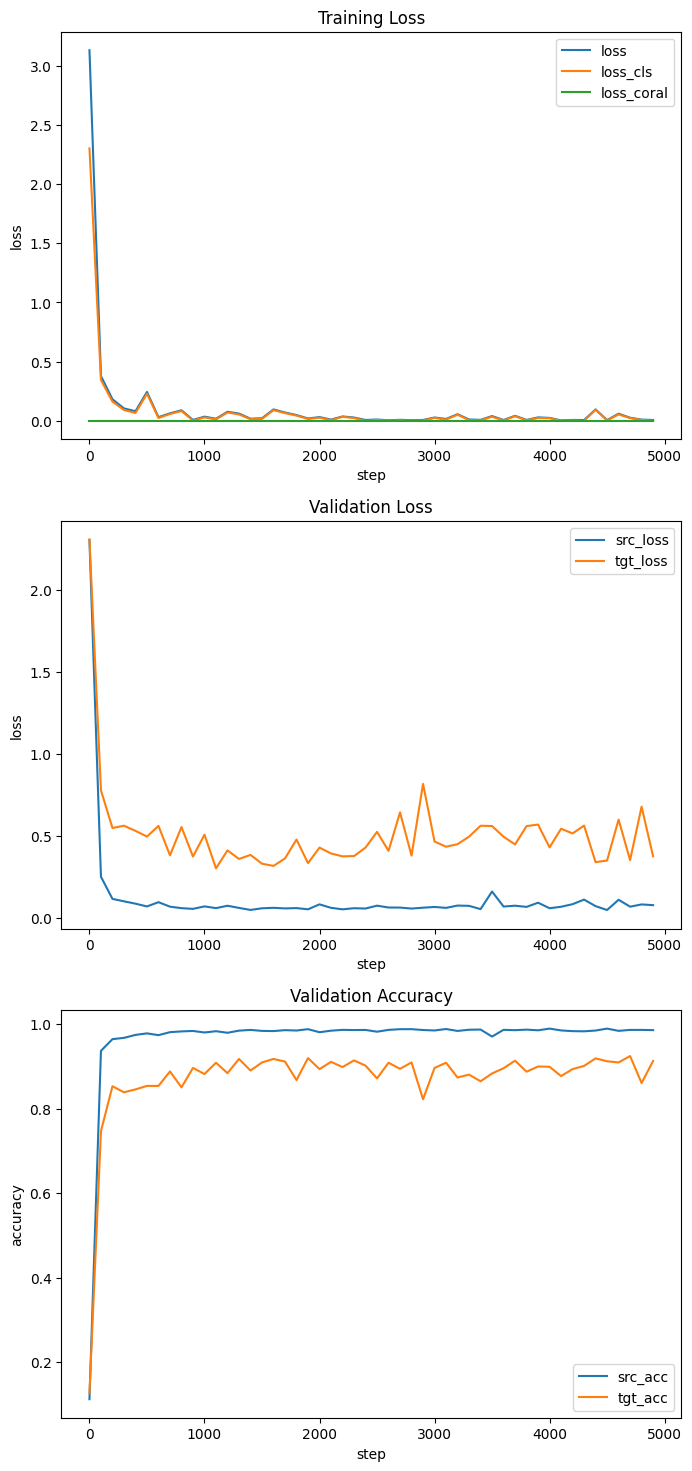

In [9]:
plt.figure(figsize=(8, 18))
plt.subplot(3, 1, 1)
plt.plot(train_stats[:, 0], train_stats[:, 1], label='loss')
plt.plot(train_stats[:, 0], train_stats[:, 2], label='loss_cls')
plt.plot(train_stats[:, 0], train_stats[:, 3], label='loss_coral')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Training Loss')

plt.subplot(3, 1, 2)
plt.plot(val_stats[:, 0], val_stats[:, 1], label='src_loss')
plt.plot(val_stats[:, 0], val_stats[:, 3], label='tgt_loss')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Validation Loss')

plt.subplot(3, 1, 3)
plt.plot(val_stats[:, 0], val_stats[:, 2], label='src_acc')
plt.plot(val_stats[:, 0], val_stats[:, 4], label='tgt_acc')
plt.legend()
plt.xlabel('step')
plt.ylabel('accuracy')
plt.title('Validation Accuracy')
plt.show()

### Evaluate the best model

In [10]:
model.load_state_dict(torch.load(log_dir/'tgt_best_model.pth'))

src_loss, src_acc = evaluate(model, src_test, nn.CrossEntropyLoss())
tgt_loss, tgt_acc = evaluate(model, tgt_test, nn.CrossEntropyLoss())

print('Adapted model:')
print(f'src_test -> loss: {src_loss:.4f}, acc: {src_acc:.4f}')
print(f'tgt_test -> loss: {tgt_loss:.4f}, acc: {tgt_acc:.4f}')

Adapted model:
src_test -> loss: 0.0444, acc: 0.9862
tgt_test -> loss: 0.4697, acc: 0.8724
